In [597]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [710]:
filepath = "../COVID Healthy diet dataset/Food_Supply_Quantity_kg_Data.csv"

df = pd.read_csv(filepath)

In [711]:
df.describe()

,Alcoholic Beverages,Animal fats,Animal Products,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,Milk - Excluding Butter,...,Treenuts,Vegetable Oils,Vegetables,Vegetal Products,Obesity,Confirmed,Deaths,Recovered,Active,Population
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,...,170.000000,170.000000,170.000000,170.000000,167.000000,162.000000,162.000000,162.000000,159.000000,1.700000e+02
mean,3.022971,0.221064,12.181871,0.013994,11.800347,0.470570,1.387195,5.621405,3.375934,6.519776,...,0.117474,0.851554,6.085912,37.814834,18.707784,0.612826,0.014382,0.421544,0.170407,4.452364e+07
std,2.382243,0.278304,5.852635,0.129382,5.824870,0.331209,1.257382,3.152849,1.762911,5.020379,...,0.146143,0.445335,3.560148,5.852943,9.633557,0.731432,0.020971,0.585557,0.291275,1.564182e+08
min,0.000000,0.001000,1.739100,0.000000,3.401400,0.023900,0.034200,0.659600,0.356000,0.096300,...,0.000000,0.091500,0.857000,23.113200,2.100000,0.000318,0.000000,0.000000,0.000000,5.400000e+04
25%,0.895625,0.040225,7.236850,0.000000,7.226850,0.187575,0.557100,3.541950,1.891475,2.172250,...,0.020750,0.507700,3.616500,33.552775,8.500000,0.072914,0.001141,0.039945,0.005022,2.816250e+06
50%,2.866150,0.116850,12.097550,0.000000,10.142750,0.460150,1.029250,5.021250,3.424750,5.336900,...,0.079950,0.774450,5.028100,37.900700,21.200000,0.361892,0.005132,0.166687,0.041464,1.018150e+07
75%,4.710950,0.253900,16.444125,0.001400,15.148950,0.644150,1.821275,6.827750,4.422450,10.407100,...,0.148650,1.070900,7.801650,42.762775,25.700000,0.918560,0.016602,0.537198,0.225449,3.271625e+07
max,15.370600,1.355900,26.886500,1.679400,29.804500,1.696000,8.795900,19.302800,8.170000,20.837800,...,0.756900,2.202600,19.299500,48.258500,45.600000,3.308116,0.102849,3.020768,1.726644,1.402385e+09


Setting the 'Country' column as the index.

In [712]:
df.set_index("Country", inplace=True)

Removing unnecessary column (only contains information about the unit of rest of the columns)

In [713]:
to_drop = ["Unit (all except Population)", "Deaths", "Active", "Recovered"]
df.drop(columns=to_drop, inplace=True, axis=1)

Converting 'string' type columns to numeric datatype. 

Dataset contains any percentage below 2.5% denotes as '<2.5'. Converting those values to 2.0 just as a crude way to handle the issue.

In [714]:
df['Undernourished'] = df['Undernourished'].replace('<2.5', 2.0)

In [715]:
df['Undernourished'] = pd.to_numeric(df['Undernourished'])

Ensuring all the columns are numeric

In [716]:
df.dtypes.value_counts()

float64    27
dtype: int64

Vizualizing the data with a heatmap to see where the missing values lie, we ca see that -

Other than features such as Obesity and Undernourished %, there are columns that will serve as label data which is missing ( COVID Confirmed, Deatth, Recovered, Active cases). These rows would be useless, since the feature data will give no insight on the COVID stats).

We will drop these rows.

<AxesSubplot:ylabel='Country'>

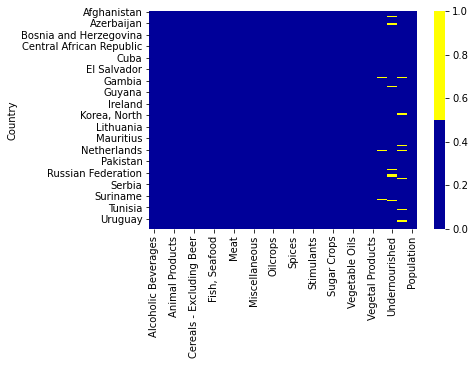

In [717]:
import seaborn as sns
cols = df.columns
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

In [718]:
df = df[df['Confirmed'].notna()]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

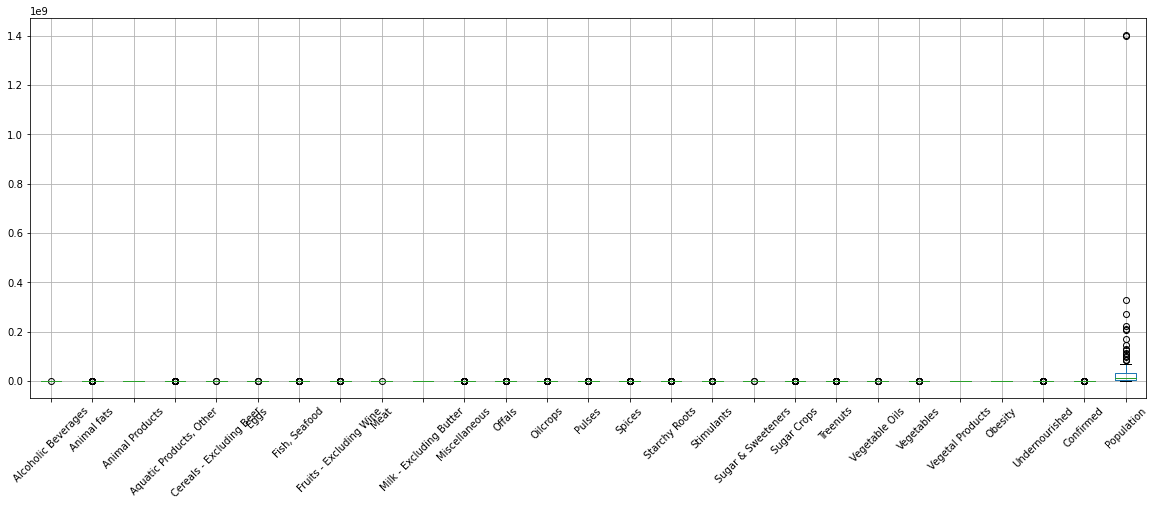

In [719]:
plt.figure(figsize = (20,7))
ax = df.boxplot()
plt.setp(ax.get_xticklabels(), rotation=45)

The population features ranges from 10^4 to 10^9. Scaling the population to 10 millions (to remove bias due to very high values) 

In [720]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['Population'] = scaler.fit_transform(np.array(df['Population']).reshape(-1,1))

Now, for the remaining missing values, we will use KNN algorithm to impute the missing values.

We use sklearn to achieve this.

In [721]:
imputer = KNNImputer(missing_values=np.nan, n_neighbors=5)
df[:] = imputer.fit_transform(df)

Checking whether algorithm can successfully and that all the missing values are removed.

In [722]:
df.isnull().values.any()

False

Now that we have cleaned the data, let's visualize the dataset to see if there are some outliers.

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

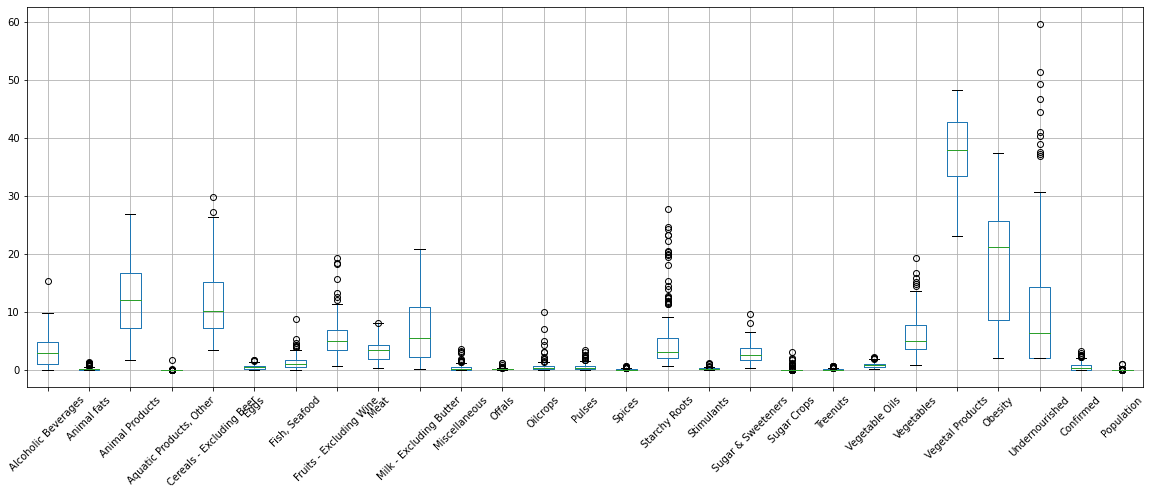

In [723]:
plt.figure(figsize = (20,7))
ax = df.boxplot()
plt.setp(ax.get_xticklabels(), rotation=45)

We can see that there is an outlier in the population column, so let's plot this feature separately.

Defining the features and labels.

In [724]:
# Separating out the features
features = ['Alcoholic Beverages',
 'Animal Products',
 'Animal fats',
 'Aquatic Products, Other',
 'Cereals - Excluding Beer',
 'Eggs',
 'Fish, Seafood',
 'Fruits - Excluding Wine',
 'Meat',
 'Miscellaneous',
 'Milk - Excluding Butter',
 'Offals',
 'Oilcrops',
 'Pulses',
 'Spices',
 'Starchy Roots',
 'Stimulants',
 'Sugar Crops',
 'Sugar & Sweeteners',
 'Treenuts',
 'Vegetal Products',
 'Vegetable Oils',
 'Vegetables',
 'Obesity',
 'Undernourished',
 'Population']

l1 = ['Confirmed']

# Separating the features
x = df.loc[:, features]

# Separating the target
y1 = df.loc[:,l1]

In [725]:
# Standardizing the features
x = StandardScaler().fit_transform(x)
x = pd.DataFrame(x, index=df.index, columns=features)

<AxesSubplot:ylabel='Country'>

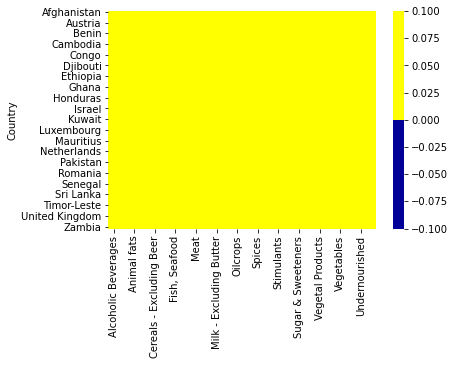

In [726]:
import seaborn as sns
cols = x.columns
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(x[cols].isnull(), cmap=sns.color_palette(colours))

<AxesSubplot:>

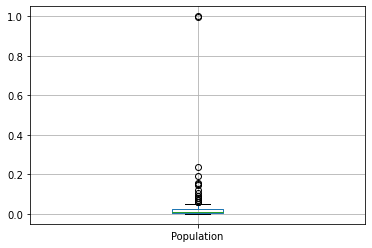

In [727]:
df.boxplot(column='Population')

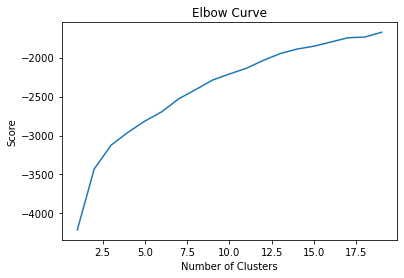

In [728]:
from scipy.spatial.distance import cdist

Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(x).score(x) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [729]:
corr = x.corr()

<AxesSubplot:>

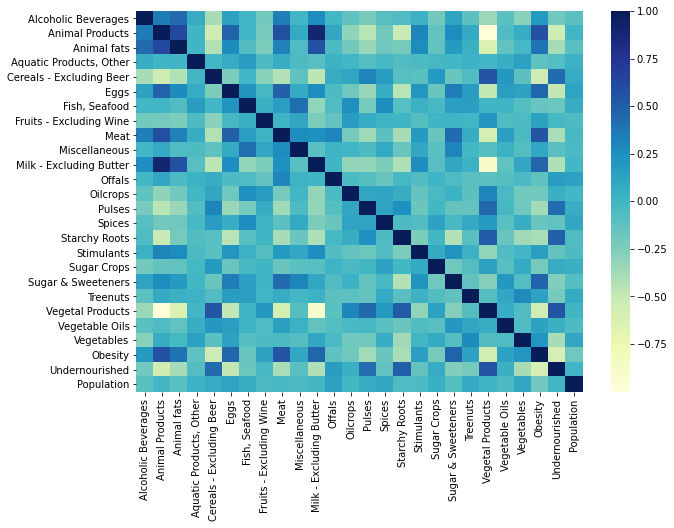

In [730]:
plt.figure(figsize = (10,7))
sns.heatmap(corr, cmap="YlGnBu")

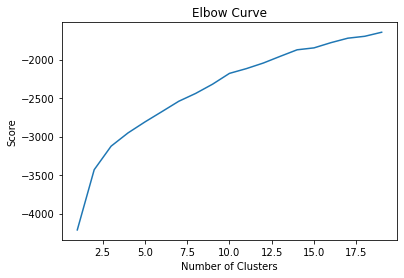

In [731]:
from scipy.spatial.distance import cdist

Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(x).score(x) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [732]:
x.shape[1]

26

In [733]:
from sklearn.decomposition import PCA
pca = PCA(n_components=26)
principalComponents = pca.fit_transform(x)
# principalDf = pd.DataFrame(data = principalComponents
#              , columns = ['principal component 1', 'principal component 2'])

In [734]:
explained_variance = pca.explained_variance_ratio_

In [735]:
num_principal_components = 0
cum_exp_var = 0
cumulative_var = []
for i in range(len(explained_variance)):
    cum_exp_var += explained_variance[i]
    cumulative_var.append(explained_variance[i])
    if(cum_exp_var>= 0.99):
        num_principal_components = i+1
        break

In [736]:
num_principal_components

22

<AxesSubplot:>

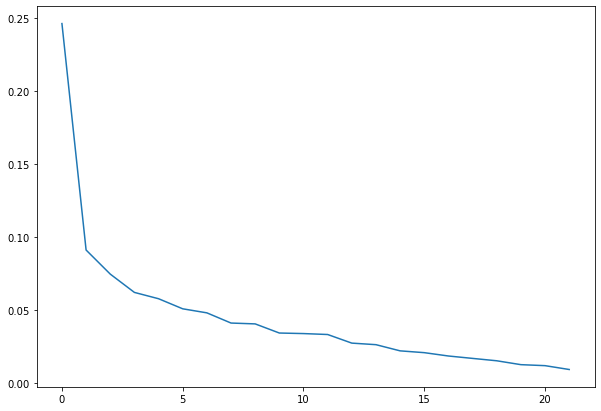

In [737]:
plt.figure(figsize = (10,7))
sns.lineplot(x=range(num_principal_components), y=cumulative_var)